In [2]:
# !unzip "/content/individual_stocks_5yr.zip" -d "/content"
folder_dir = "/content/individual_stocks_5yr/individual_stocks_5yr"

In [3]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

import matplotlib.pyplot as plt

In [4]:
# Pick one stock
dir = "/content/individual_stocks_5yr/individual_stocks_5yr/AAPL_data.csv"
df = pd.read_csv(dir)
change = np.array(df['close'] - df['open'])
close_price = np.array(df['close'])
close_price[:20]

array([67.8542, 68.5614, 66.8428, 66.7156, 66.6556, 65.7371, 65.7128,
       64.1214, 63.7228, 64.4014, 63.2571, 64.1385, 63.5099, 63.0571,
       61.4957, 60.0071, 61.5919, 60.8088, 61.5117, 61.6742])

In [5]:
# Pick how many previous days to get the target price
day_shift = 7

previous_days = np.zeros((len(close_price)-day_shift, day_shift))
for i in range(len(close_price)-day_shift):
  previous_days[i] = close_price[i:i+day_shift]

# Reshape input to be 3 dimension [sample, previous_days, features]
previous_days = previous_days[..., np.newaxis]
target = close_price[day_shift:]

print(previous_days.shape)
print(target.shape)

(1252, 7, 1)
(1252,)


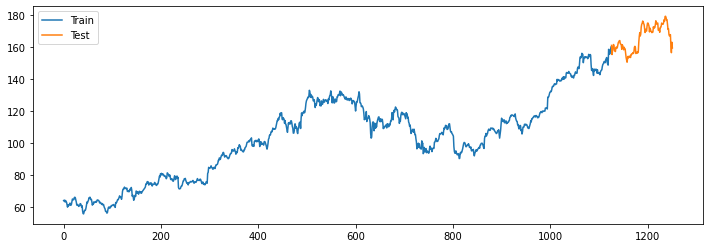

In [6]:
# Split test/train data
# Can't use cross validation for time series data
split_percent = 0.9
N = target.shape[0]

X_train, y_train = previous_days[:int(N*split_percent)], target[:int(N*split_percent)]
X_test, y_test = previous_days[int(N*split_percent):], target[int(N*split_percent):]

# Plot
day = np.arange(0, N)
plt.figure(figsize=(12,4))
plt.plot(day[:int(N*split_percent)], y_train)
plt.plot(day[int(N*split_percent):], y_test)
plt.legend(['Train','Test'])
plt.show()

In [7]:
'''
parameters
'''
lr = 0.001
epoch = 50

model = Sequential()

model.add(layers.Input((day_shift, 1)))
model.add(layers.LSTM(128))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=lr))
model.add(layers.Dense(32))
model.add(layers.LeakyReLU(alpha=lr))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,929
Trainable params: 76,929
Non-traina

In [ ]:
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=lr),
              metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs = epoch)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Mean absolute error:', score[1])

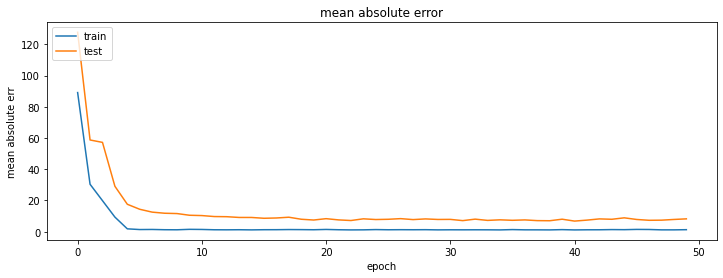

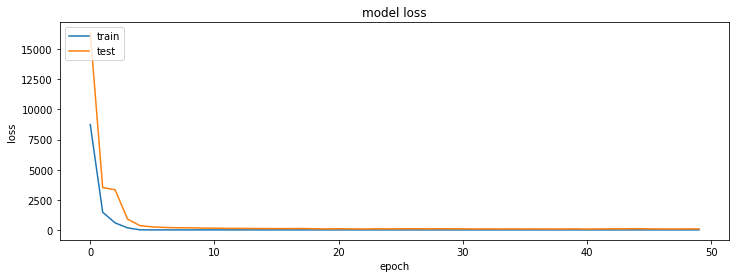

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('mean absolute err')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

36/36 [==============================] - 1s 5ms/step


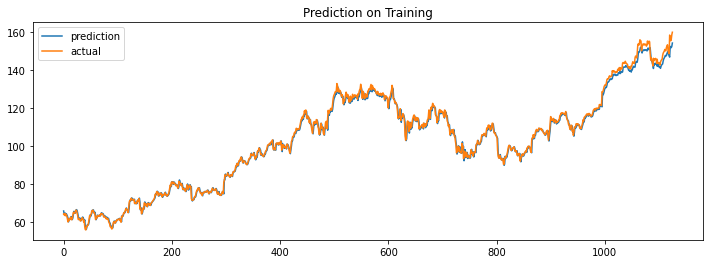

In [ ]:
# Show Prediction on Training
prediction = model.predict(X_train).flatten()

plt.figure(figsize=(12,4))
plt.plot(prediction)
plt.plot(y_train)
plt.title("Prediction on Training")
plt.legend(['prediction','actual'])

4/4 [==============================] - 0s 6ms/step


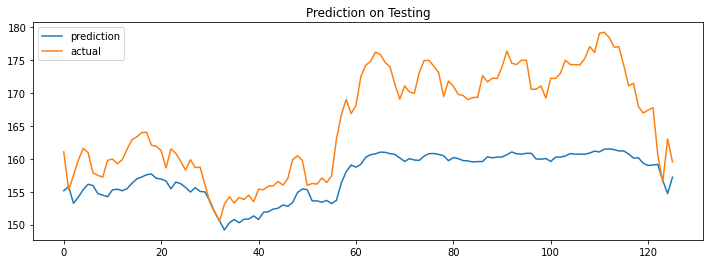

In [ ]:
# Show Prediction on Testing
prediction = model.predict(X_test).flatten()

plt.figure(figsize=(12,4))
plt.plot(prediction)
plt.plot(y_test)
plt.title("Prediction on Testing")
plt.legend(['prediction','actual'])